数据集基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2732 entries, 0 to 2731
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2732 non-null   object 
 1   Year                             2732 non-null   int64  
 2   Status                           2732 non-null   object 
 3   Life expectancy                  2724 non-null   float64
 4   Adult Mortality                  2724 non-null   float64
 5   infant deaths                    2732 non-null   int64  
 6   Alcohol                          2547 non-null   float64
 7   percentage expenditure           2732 non-null   float64
 8   Hepatitis B                      2207 non-null   float64
 9   Measles                          2732 non-null   int64  
 10   BMI                             2699 non-null   float64
 11  under-five deaths                2732 non-null   int64  
 12  Polio      

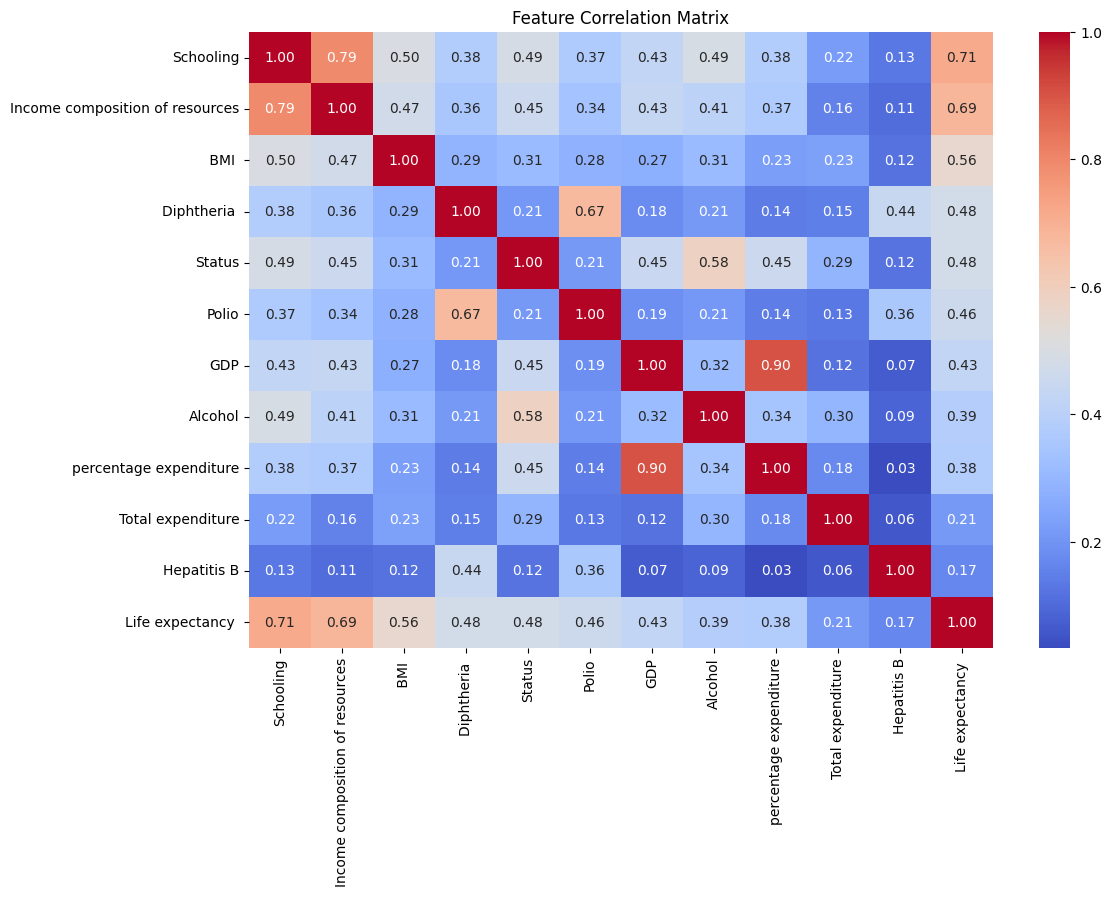


选择的特征： ['Schooling', 'Income composition of resources', ' BMI ', 'Diphtheria ', 'Status', 'Polio', 'GDP', 'Alcohol', 'percentage expenditure', ' thinness 5-9 years', ' thinness  1-19 years', ' HIV/AIDS', 'Adult Mortality']

线性回归模型 - 均方误差 (MSE): 17.766064255276813
线性回归模型 - R² 得分: 0.8037108510130677

线性回归模型 - 权重（系数）：
 Schooling                          2.412605
Income composition of resources    1.117857
Diphtheria                         1.089775
 BMI                               0.968938
Polio                              0.650028
Status                             0.623387
GDP                                0.438684
percentage expenditure             0.162625
 thinness 5-9 years                0.092571
Alcohol                            0.025515
 thinness  1-19 years             -0.542200
Adult Mortality                   -2.404588
 HIV/AIDS                         -2.515469
dtype: float64


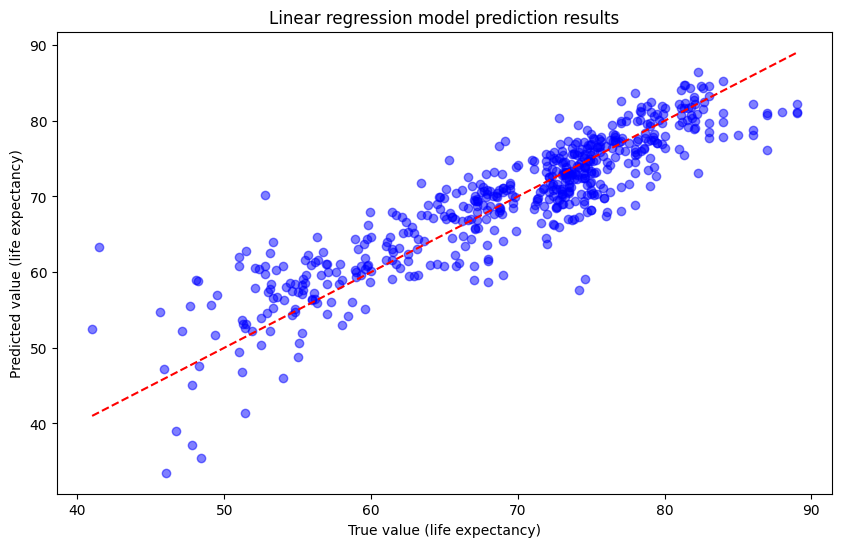

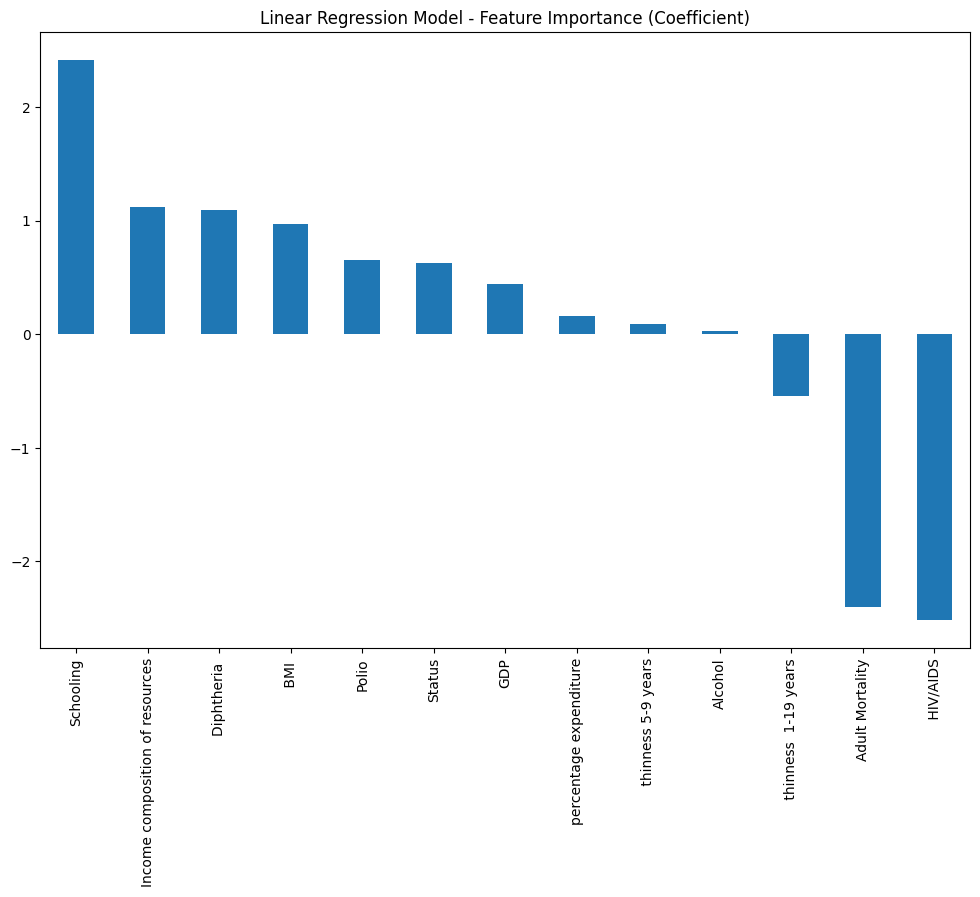

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ==============================
# 第 1 部分：数据集描述与特征选择 (EDA)
# ==============================

# 加载数据集
data = pd.read_csv('life_expectancy_data.csv')

# 数据集基本信息
print("数据集基本信息：")
print(data.info())

# 查看前几行数据
print("\n数据集预览：")
print(data.head())

# 检查缺失值
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("\n缺失值统计：\n", missing_values)

# 填充缺失值（使用中位数）
data.fillna(data.median(numeric_only=True), inplace=True)

# 编码分类变量
data['Status'] = data['Status'].map({'Developing': 0, 'Developed': 1})

# 删除非数值列（'Country', 'Year'）
data_numeric = data.drop(columns=['Country', 'Year'])

# 计算特征与目标变量（Life expectancy）的相关性
correlation_matrix = data_numeric.corr()
correlation_with_target = correlation_matrix['Life expectancy '].sort_values(ascending=False)
print("\n与预期寿命相关性：\n", correlation_with_target)

# 根据相关性筛选特征（删除负相关特征）
selected_features = correlation_with_target[correlation_with_target > 0].index.tolist()
selected_features.remove('Life expectancy ')  # 删除目标变量

print("\n选择的特征：", selected_features)

# 重新计算删除特征后的相关性矩阵
data_selected = data[selected_features + ['Life expectancy ']]
correlation_matrix_selected = data_selected.corr()

# 可视化删除负相关特征后的相关性矩阵
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_selected, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()
# 根据相关性筛选特征
selected_features = correlation_with_target[abs(correlation_with_target) > 0.3].index.tolist()
selected_features.remove('Life expectancy ')

print("\n选择的特征：", selected_features)

# ==============================
# 第 2 部分：根据 EDA 结果构建流水线 (DVC)
# ==============================
# DVC 步骤：
# 1. 初始化 DVC：
#    dvc init
#
# 2. 创建 DVC 阶段：
# - 数据预处理阶段：
#    dvc run -n preprocess -d life_expectancy_data.csv -o processed_data.csv python preprocess.py
#
# - 特征选择阶段：
#    dvc run -n feature_selection -d processed_data.csv -o selected_features.csv python feature_selection.py
#
# - 模型训练阶段：
#    dvc run -n train_model -d selected_features.csv -o model.pkl python train_model.py
#
# - 模型评估阶段：
#    dvc run -n evaluate -d model.pkl -o metrics.json python evaluate.py
#
# 3. 查看 DVC 流水线图：
#    dvc dag

# ==============================
# 第 3 部分：线性回归模型实现
# ==============================

# 数据预处理：选择相关特征和目标变量
X = data[selected_features]
y = data['Life expectancy ']

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 创建线性回归模型
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# 预测
y_pred = linear_model.predict(X_test)

# 模型评估
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n线性回归模型 - 均方误差 (MSE): {mse}")
print(f"线性回归模型 - R² 得分: {r2}")

# 查看权重（系数）
coefficients = pd.Series(linear_model.coef_, index=selected_features).sort_values(ascending=False)
print("\n线性回归模型 - 权重（系数）：\n", coefficients)

# 绘制预测值和真实值的对比图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True value (life expectancy)")
plt.ylabel("Predicted value (life expectancy)")
plt.title("Linear regression model prediction results")
plt.show()

# 显示特征的重要性
plt.figure(figsize=(12, 8))
coefficients.plot(kind='bar')
plt.title('Linear Regression Model - Feature Importance (Coefficient)')
plt.show()

# ==============================
# 完成
# ==============================
